## Reconstructing Horndeski theories via the Gaussian Process: Model building

This is part 2 of a two-part notebook on using the Gaussian process (GP) [1] to reconstruct Horndeski theories. In this notebook, we use the reconstructed Hubble function $H(z)$ and its derivatives to obtain the potentials in different subclasses of Horndeski theories. Specifically, we focus on quintessence [2], designer Horndeski [3], and tailoring Horndeski [4].

References

[1] M. Seikel, C. Clarkson and M. Smith, Reconstruction of dark energy and expansion dynamics
using gaussian processes, JCAP 06 (2012) 036 [1204.2832].

[2] N. C. Tsamis and R. P. Woodard, Nonperturbative models for the quantum gravitational back
reaction on inflation, Annals Phys. 267 (1998) 145 [hep-ph/9712331].

[3] R. Arjona, W. Cardona and S. Nesseris, Designing Horndeski and the effective fluid approach,
Phys. Rev. D 100 (2019) 063526 [1904.06294].

[4] R. C. Bernardo and I. Vega, Tailoring cosmologies in cubic shift-symmetric Horndeski gravity,
JCAP 10 (2019) 058 [1903.12578].

### 0. Preparation: Reconstructing H'(z), cov(H(z), H'(z))

This intermediate section prepares the analysis for Secs. 1-3.

In [1]:
%matplotlib inline
import numpy as np
from numpy import loadtxt, savetxt
from scipy.constants import c
import scipy.stats as st
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (ConstantKernel, RBF)

from scipy.linalg import block_diag
from numpy.random import multivariate_normal as N

We prepare the following functions below in order to reconstruct the derivative of a GP and the covariance between $H(z)$ and $H'(z)$ for an RBF kernel.

In [2]:
def kRBF(x, y, l):
    '''returns the RBF kernel
    RBF(x, y, l) = \exp(-(x - y)^2/(2 l^2))'''
    
    d = x - y
    
    return np.exp(-(d**2)/(2*(l**2)))

def Dx_kRBF(x, y, l):
    '''returns the derivative of the RBF kernel
    with respect to x'''
    
    d = x - y
    
    return -(d/(l**2))*kRBF(x, y, l)

def Dy_kRBF(x, y, l):
    '''returns the derivative of the RBF kernel
    with respect to y'''
    
    return -Dx_kRBF(x, y, l)

def Dxy_kRBF(x, y, l):
    '''returns the derivative of the RBF kernel
    with respect to x and y'''
    
    d = x - y
    Dxy_factor = (l**2 - d**2)/(l**4)
    
    return Dxy_factor*kRBF(x, y, l)

# master function for obtaining f'(x) and cov[f'(x)]

def get_K_plus_C_inv(Z, dY, l, Amp):
    '''constructs matrix inverse of K + C at training points
    Z = training positions
    dY = uncertainty in Y(Z)
    l, Amp = RBF kernel hyperparameters, i.e., kernel = Amp*RBF(l)'''
    
    C = np.diag(dY**2)

    K_ZZ = np.diag(dY*0)

    for i in np.arange(0, len(Z)):
        for j in np.arange(0, len(Z)):
            K_ij = kRBF(Z[i], Z[j], l)
            K_ZZ[i, j] = K_ij

    return np.linalg.inv(Amp*K_ZZ + C)

def df1_ave(Z, Y, K_plus_C_inv, z, l, Amp):
    '''returns mean of f'(z) for an RBF kernel
    of length l and amplitude Amp with training points (Z, Y)
    
    K_plus_C_inv = matrix inverse of K + C at training points'''

    Kn0 = Amp*Dx_kRBF(z, Z, l)

    return Kn0 @ K_plus_C_inv @ Y

def df1_cov(Z, K_plus_C_inv, z, l, Amp):
    '''returns the covariance of f'(z) for an RBF kernel
    of length l and amplitude Amp with training points (Z, Y)
    
    K_plus_C_inv = matrix inverse of K + C at training points'''

    Kn0 = Amp*Dx_kRBF(z, Z, l)
    K0n = Amp*Dy_kRBF(Z, z, l)
    Knn = Amp*Dxy_kRBF(z, z, l)

    return Knn - (Kn0 @ K_plus_C_inv @ K0n)

def df_predict(Z, Y, dY, z_star, l, Amp):
    '''returns the derivative of GP and its covariance
    for an RBF kernel of length scale l and amplitude Amp
    
    Z = positions where f(z) was measured/trained
    Y = mean of the observations of f(z) at z = Z
    dY = error in the observations of f(z) at z = Z
    z_star = positions where f'(z) will be evaluated'''

    K_plus_C_inv = get_K_plus_C_inv(Z, dY, l, Amp)
    
    df_arr = z_star*0 # setup array for f'(z_star)
    sigdf_arr = z_star*0 # setup array for cov(f')
    
    for i in np.arange(0, len(z_star)):
        df_arr[i] = df1_ave(Z, Y, K_plus_C_inv, z_star[i], l, Amp)
        sigdf_arr[i] = df1_cov(Z, K_plus_C_inv, z_star[i], l, Amp)
        
    return df_arr, np.sqrt(sigdf_arr)

def cov_fn_fm(Z, K_plus_C_inv, z, l, Amp):
    '''returns the 2x2 covariance matrix of a GP and its first derivative
    at a query point z provided training points (Z, Y) and kernel Amp*RBF(l)
    
    K_plus_C_inv = matrix inverse of K + C at training points'''

    # 00-term
    term_1 = Amp*kRBF(z, z, l)
    term_2 = (Amp*kRBF(z, Z, l)) @ K_plus_C_inv @ (Amp*kRBF(Z, z, l))
    cov_f0_f0 = term_1 - term_2
    
    # 11-term
    K10 = Amp*Dx_kRBF(z, Z, l)
    K01 = Amp*Dy_kRBF(Z, z, l)
    K11 = Amp*Dxy_kRBF(z, z, l)
    
    cov_f1_f1 = K11 - (K10 @ K_plus_C_inv @ K01)
    
    # 01-term: cross-correlation
    K01_cc = Amp*Dy_kRBF(z, z, l)
    K00_cc = Amp*kRBF(z, Z, l)
    K01_cc_zzstar = Amp*Dy_kRBF(Z, z, l)
    
    cov_f0_f1 = K01_cc - (K00_cc @ K_plus_C_inv @ K01_cc_zzstar)

    return np.array([[cov_f0_f0, cov_f0_f1], \
                     [cov_f0_f1, cov_f1_f1]])

Here is the reconstruction of $H(z)$ and $H'(z)$ per $H_0$ prior.

In [3]:
H0_priors = {'R19': {'ave': 74.03, 'std': 1.42},
             'TRGB': {'ave': 69.8, 'std': 1.9},
             'P18': {'ave': 67.4, 'std': 0.5}}

# import data from notebook part 1
sbc_data = {}
for H0_prior in H0_priors:
    sbc_data[H0_prior] = loadtxt('sbc_data_' + H0_prior + '.txt')
    
# setup query redshifts
z_min = 1e-5
z_max = 2
n_div = 100
z_star = np.linspace(z_min, z_max, n_div)

sbc_rec = {}

for H0_prior in H0_priors:
    
    sbc_data_H0_prior = sbc_data[H0_prior]
    z_sbc = sbc_data_H0_prior[:, 0]
    Hz_sbc = sbc_data_H0_prior[:, 1]
    sigHz_sbc = sbc_data_H0_prior[:, 2]
    
    l_0 = np.median(z_sbc)
    l_prior = (min(z_sbc), max(z_sbc)*10)
    kernel = ConstantKernel()*RBF(l_0, l_prior)

    gp = GaussianProcessRegressor(kernel = kernel,
                                  alpha = sigHz_sbc**2,
                                  n_restarts_optimizer = 10)
    gp.fit(z_sbc.reshape(-1, 1), Hz_sbc)

    Amp = gp.kernel_.get_params()['k1__constant_value']
    l = gp.kernel_.get_params()['k2__length_scale']
    
    print(H0_prior, gp.kernel_)
    
    # compute chi^2 for reconstruction
    Hz_rec_at_sbc = gp.predict(z_sbc.reshape(-1, 1))
    chi2 = np.sum(((Hz_rec_at_sbc - Hz_sbc)/sigHz_sbc)**2)
    
    print('chi^2 =', np.round(chi2, 1))
    print('reduced chi^2 =', np.round(chi2/(len(z_sbc) - 2), 1))

    # predict H(z)
    Hz_rec, sigHz_rec = gp.predict(z_star.reshape(-1, 1),
                                   return_std = True)
    
    # predict H'(z)
    Hpz_rec, sigHpz_rec = df_predict(z_sbc, Hz_sbc, sigHz_sbc,
                                     z_star, l, Amp)
    
    sbc_H0_dict = {}
    
    sbc_H0_dict['z'] = z_star
    sbc_H0_dict['Hz'] = Hz_rec
    sbc_H0_dict['sigHz'] = sigHz_rec
    sbc_H0_dict['Hpz'] = Hpz_rec
    sbc_H0_dict['sigHpz'] = sigHpz_rec
    sbc_H0_dict['chi2'] = chi2
    
    K_plus_C_inv = get_K_plus_C_inv(z_sbc, sigHz_sbc, l, Amp)
    cov_Hz_Hpz_rec = [cov_fn_fm(z_sbc, K_plus_C_inv, zs, l, Amp)
                     for zs in z_star]
    
    sbc_H0_dict['cov_Hz_Hpz'] = np.array(cov_Hz_Hpz_rec)
    
    sbc_rec[H0_prior] = sbc_H0_dict

R19 128**2 * RBF(length_scale=1.74)
chi^2 = 24.8
reduced chi^2 = 0.7
TRGB 133**2 * RBF(length_scale=1.92)
chi^2 = 19.7
reduced chi^2 = 0.5
P18 129**2 * RBF(length_scale=1.9)
chi^2 = 25.6
reduced chi^2 = 0.7


We view the reconstructions of $H(z)$ and $H'(z)$ below.

chi^2 (LambdaCDM) = 29.9
reduced chi^2 (LambdaCDM) = 0.9


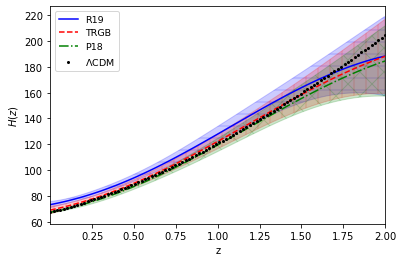

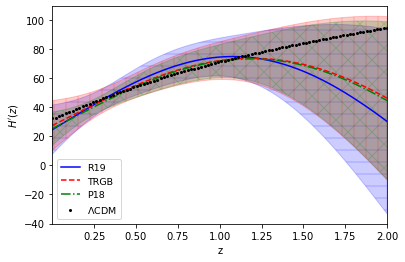

In [4]:
def plot_sbc_rec(H0_prior, ls, fc, hatch, n = 0):
    '''plots the GP H(z) or its derivative (if n != 0)
    for a given H0-prior
    
    H0_prior = string ('R16', 'TRGB', 'P18')
    ls = line color & style, e.g., 'r-', 'k--'
    fc = face color of 2*sigma regions, e.g., 'r', 'k'
    n = 1, 2 returns H'(z) and H''(z) instead
    '''
    
    z = sbc_rec[H0_prior]['z']
    
    if n == 0:
        Hz = sbc_rec[H0_prior]['Hz']
        sigHz = sbc_rec[H0_prior]['sigHz']
        
        plt.plot(z, Hz, ls, label = H0_prior)
        plt.fill_between(z, Hz - 2*sigHz, Hz + 2*sigHz,
                         alpha = .2, facecolor = fc,
                         edgecolor = fc, hatch = hatch)
        
    else:
        Hpz = sbc_rec[H0_prior]['Hpz']
        sigHpz = sbc_rec[H0_prior]['sigHpz']
        
        plt.plot(z, Hpz, ls, label = H0_prior)
        plt.fill_between(z, Hpz - 2*sigHpz, Hpz + 2*sigHpz,
                         alpha = .2, facecolor = fc,
                         edgecolor = fc, hatch = hatch)
        
fig = plt.figure()
plot_sbc_rec('R19', 'b-', 'b', '-')
plot_sbc_rec('TRGB', 'r--', 'r', '|')
plot_sbc_rec('P18', 'g-.', 'g', 'x')

# Omega_m, Omega_Lambda Planck 2018 (Table 2 arXiv:1807.06209)
om0_P18 = 0.3153 # Omega_m
sigom0_P18 = 0.0073

ol0_P18 = 0.6847 # Omega_Lambda = 1 - Omega_m
sigol0_P18 = 0.0073

# plot LambdaCDM P18 fit with chi^2
Hz_lcdm = (H0_priors['P18']['ave'])* \
          np.sqrt(om0_P18*(1 + z_star)**3 + ol0_P18)
Hz_lcdm_at_sbc = (H0_priors['P18']['ave'])* \
                 np.sqrt(om0_P18*(1 + sbc_data['P18'][:, 0])**3 + ol0_P18)
chi2_lcdm = np.sum(((Hz_lcdm_at_sbc - sbc_data['P18'][:, 1]) \
                    /sbc_data['P18'][:, 2])**2)
nu_lcdm = len(sbc_data['P18'][:, 0]) - 6
plt.plot(z_star, Hz_lcdm, 'k.', markersize = 4,
         label = r'$\Lambda$CDM')
print('chi^2 (LambdaCDM) =', np.round(chi2_lcdm, 1))
print('reduced chi^2 (LambdaCDM) =', np.round(chi2_lcdm/nu_lcdm, 1))

plt.xlim(z_min, z_max)
plt.xlabel('z')
plt.ylabel(r'$H(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

fig = plt.figure()
plot_sbc_rec('R19', 'b-', 'b', '-', n = 1)
plot_sbc_rec('TRGB', 'r--', 'r', '|', n = 1)
plot_sbc_rec('P18', 'g-.', 'g', 'x', n = 1)

Hpz_lcdm = np.gradient(Hz_lcdm, z_star)
plt.plot(z_star, Hpz_lcdm, 'k.', markersize = 4,
         label = r'$\Lambda$CDM')

plt.xlim(z_min, z_max)
plt.xlabel('z')
plt.ylabel(r'$H^\prime(z)$')
plt.legend(loc = 'lower left', prop = {'size': 9.5})
plt.show()

### 1. Quintessence potential construction

In this section, we consider quintessence potential models, or rather, scalar-tensor theories with energy density and pressure given by $\rho_\phi = \dot{\phi}^2/2 + V(\phi)$ and $P_\phi = \dot{\phi}^2/2 - V(\phi)$, respectively.
Using the Friedmann equations, it can be shown that the potential $V(\phi)$ can be built from the Hubble function $H(z)$ as
\begin{equation}
V\left( \phi (z) \right) = - \frac{3}{2} H_0^2 (1 + z)^3 \Omega_{m0} - 3 H_0^2 \Omega_\Lambda + H(z)\left(3H(z) - (1 + z)H'(z)\right)
\end{equation}
where $\Omega_{m0}$ is the present fraction of nonrelativistic (clustering) matter in the Universe's energy budget. The scalar field's kinetic term can also be obtained by solving
\begin{equation}
\phi^\prime (z)^2 = - \frac{3 H_0^2 (1 + z) \Omega_{m0}}{ H(z)^2 } + \frac{2 H'(z)}{H(z) (1 + z)} .
\end{equation}
Most importantly, the dark energy equation of state can be reconstructed:
\begin{equation}
w_\phi(z) = \dfrac{ \dot{\phi}^2/2 - V(\phi) }{ \dot{\phi}^2/2 + V(\phi) }
\end{equation}
where $\dot{\phi} = -H(z)(1 + z)\phi'(z)$.

These equations are prepared via a Monte-Carlo routine in the next line.

In [5]:
def get_V_phip2_w_de_quint(H0_prior, om0, sigom0,
                           n_s = 1000):
    '''
    returns the mean and std of V(z),
    \phi'(z), and w_DE(z) for quintessence
    
    input:
    H0_prior = ('R16', 'TRGB', 'P18')
    om0 = prior matter energy fraction
    sigom0 = uncertainty in om0
    n_s = sampling size, default: n_s = 1000
    '''

    z = sbc_rec[H0_prior]['z']
    Hz = sbc_rec[H0_prior]['Hz']
    sigHz = sbc_rec[H0_prior]['sigHz']
    Hpz = sbc_rec[H0_prior]['Hpz']
    sigHpz = sbc_rec[H0_prior]['sigHpz']
    cov_Hz_Hpz = sbc_rec[H0_prior]['cov_Hz_Hpz']

    H0 = Hz[0]
    sigH0 = sigHz[0]

    # prepare mean and cov of full parameters
    ave_params = [np.array([Hz[i], Hpz[i], H0, om0])
                  for i in np.arange(0, len(Hz))]
    cov_params = [block_diag(C, sigH0**2, sigom0**2)
                  for C in cov_Hz_Hpz]

    Vz = np.zeros((len(z), 2))
    phip2 = np.zeros((len(z), 2))
    w_de = np.zeros((len(z), 2))
    atw_de = np.zeros((len(z), 7))
    
    atw_de_z_samps = []
    i_samps = [int(len(z)*x) for x in np.linspace(0, 1, 5)]
    if len(z) in i_samps:
        len_z_index = i_samps.index(len(z))
        i_samps[len_z_index] = len(z) - 1
    
    for i in np.arange(0, len(z)):

        V_samples = np.zeros(n_s)
        phip2_samples = np.zeros(n_s)
        w_de_samples = np.zeros(n_s)
        atw_de_samples = np.zeros(n_s)
        

        for j in np.arange(0, n_s): # jth random draw
            
            Hz_j, Hpz_j, H0_j, om0_j = N(ave_params[i], cov_params[i])

            V_j = -(3/2)*(H0_j**2)*om0_j*((1 + z[i])**3) \
                  + Hz_j*(3*Hz_j - Hpz_j*(1 + z[i]))

            phip2_j = -3*(H0_j**2)*om0_j*(1 + z[i])/(Hz_j**2) \
                      + 2*Hpz_j/(Hz_j*(1 + z[i]))

            K_j = (1/2)*((Hz_j*(1 + z[i]))**2)*phip2_j
            w_de_j = (K_j - V_j)/(K_j + V_j)

            V_samples[j] = V_j
            phip2_samples[j] = phip2_j
            w_de_samples[j] = w_de_j
            atw_de_samples[j] = np.arctan(1 + w_de_j)

        Vz[i][0] = np.mean(V_samples)
        Vz[i][1] = np.std(V_samples)

        phip2[i][0] = np.mean(phip2_samples)
        phip2[i][1] = np.std(phip2_samples)

        w_de[i][0] = np.mean(w_de_samples)
        w_de[i][1] = np.std(w_de_samples)
        
        atw_de[i][0] = np.mean(atw_de_samples)
        atw_de[i][1] = np.std(atw_de_samples)
        atw_de[i][2] = st.skew(atw_de_samples)
        atw_de[i][3] = st.kurtosis(atw_de_samples,
                                   fisher = True)
        atw_de[i][4] = np.percentile(atw_de_samples, 50) # median
        atw_de[i][5] = np.percentile(atw_de_samples,
                                     50 - 34.1) # 68.2% prob. mass
        atw_de[i][6] = np.percentile(atw_de_samples,
                                     50 + 34.1)
        
        if i in i_samps:
            
            atw_de_z_samps.append([z[i], atw_de_samples])
        
    return z, Vz, phip2, w_de, atw_de, atw_de_z_samps

We now use this below in order to constraint quintessence.

In [6]:
V_phip2_w_de_quint = {}
n_s = 1000 # sampling size at each redshift

for H0_prior in H0_priors:
    
    z, Vz, phip2, w_de, atw_de, atw_samps = \
        get_V_phip2_w_de_quint(H0_prior, om0_P18,
                               sigom0_P18, n_s = n_s)
    
    V_phip2_w_de_dict = {}
    V_phip2_w_de_dict['z'] = z
    V_phip2_w_de_dict['Vz'] = Vz
    V_phip2_w_de_dict['phip2'] = phip2
    V_phip2_w_de_dict['w_de'] = w_de
    V_phip2_w_de_dict['atw_de'] = atw_de
    V_phip2_w_de_dict['atw_samps'] = atw_samps

    V_phip2_w_de_quint[H0_prior] = V_phip2_w_de_dict

So, here are the plots for the potential, kinetic term, and the dark energy equation of state.

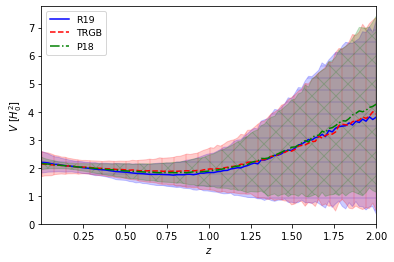

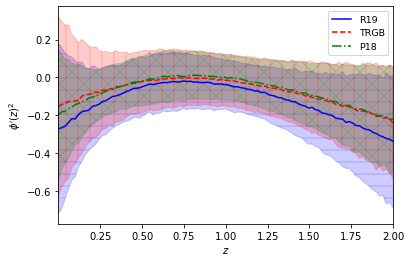

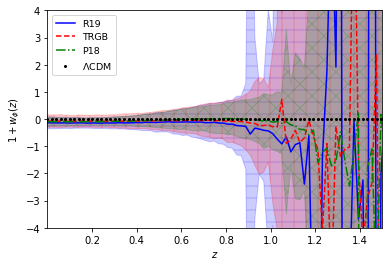

In [7]:
def plot_Vz(H0_prior, ls, fc, hatch):
    
    z = V_phip2_w_de_quint[H0_prior]['z']
    V = V_phip2_w_de_quint[H0_prior]['Vz']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(z, V[:, 0]/(H0**2), ls, label = H0_prior)
    plt.fill_between(z,
                     (V[:, 0] - 2*V[:, 1])/(H0**2),
                     (V[:, 0] + 2*V[:, 1])/(H0**2),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_phip2(H0_prior, ls, fc, hatch):
    
    z = V_phip2_w_de_quint[H0_prior]['z']
    phip2 = V_phip2_w_de_quint[H0_prior]['phip2']
    
    plt.plot(z, phip2[:, 0], ls, label = H0_prior)
    plt.fill_between(z,
                     phip2[:, 0] - 2*phip2[:, 1],
                     phip2[:, 0] + 2*phip2[:, 1],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_w_phi(H0_prior, ls, fc, hatch):
    
    z = V_phip2_w_de_quint[H0_prior]['z']
    w_de = V_phip2_w_de_quint[H0_prior]['w_de']
    
    plt.plot(z, 1 + w_de[:, 0], ls, label = H0_prior)
    plt.fill_between(z,
                     1 + w_de[:, 0] - 2*w_de[:, 1],
                     1 + w_de[:, 0] + 2*w_de[:, 1],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
# quintessence potential
fig = plt.figure()
plot_Vz('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_Vz('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_Vz('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$V$ [$H_0^2$]')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# kinetic term phi'(z)^2
fig = plt.figure()
plot_phip2('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_phip2('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_phip2('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$\phi^\prime(z)^2$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# dark energy equation of state
fig = plt.figure()
plot_w_phi('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_w_phi('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_w_phi('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.plot(z_star, np.array([0]*len(z_star)),
         'k.', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel(r'$z$')
plt.ylabel(r'$1 + w_\phi(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max*0.75)
plt.ylim(-4, 4)
plt.show()

In principle, by integrating $\phi'(z)$, the potential $V$ can be obtained in terms of the dark energy field $\phi$. However, the plot of $\phi'(z)^2$ shows that $\phi'(z)$ can be real only near the upper $2\sigma$ contours for each $H_0$ prior. In particular, it can be shown that $\langle \phi'(z)^2 \rangle > 0$ for the entire redshift range of interest, i.e., $z \in [0, 2)$, if $\Omega_{m0}$ is less than some value of about $\Omega_{m0} \sim 0.1$.

Here is the plot of the compactified dark energy equation of state.

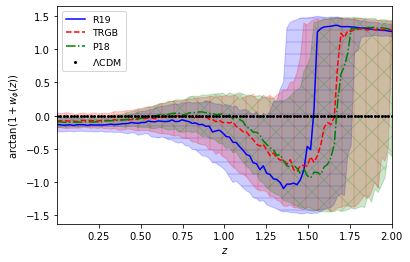

In [8]:
def plot_atw_phi(H0_prior, ls, fc, hatch):
    
    z = V_phip2_w_de_quint[H0_prior]['z']
    atw_de = V_phip2_w_de_quint[H0_prior]['atw_de']
    
    plt.plot(z, atw_de[:, 4], ls, label = H0_prior)
    plt.fill_between(z, atw_de[:, 5], atw_de[:, 6],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)

# arctaned dark energy equation of state
fig = plt.figure()
plot_atw_phi('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_atw_phi('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_atw_phi('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.plot(z_star, np.array([0]*len(z_star)),
         'k.', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel(r'$z$')
plt.ylabel(r'arctan($1 + w_\phi(z)$)')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

The above distribution shows the median and the 68.2 \% of the probability mass surrounding it. This coincodes with the mean and the $1\sigma$ confidence intervals for Gaussian distributions. However, we shall find that this is not entirely the case at high redshifts. Here is a plot of the distributions of $\arctan(1 + w_\phi(z))$ at sample redshifts.

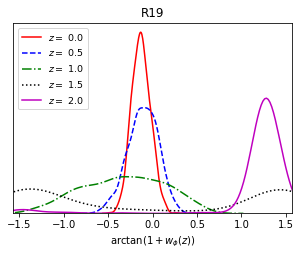

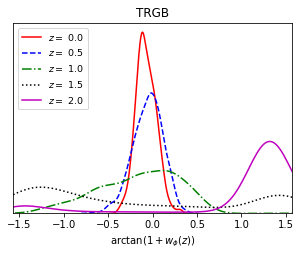

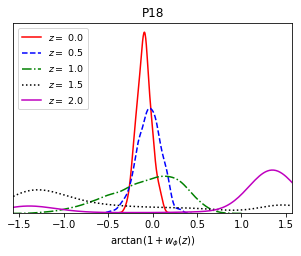

In [9]:
for H0_prior in H0_priors:
    
    atw_samps = V_phip2_w_de_quint[H0_prior]['atw_samps']
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    cl_list = ['r', 'b', 'g', 'k', 'm']
    ls_list = ['-', '--', '-.', ':', '-']
    for i in np.arange(0, len(atw_samps)):
        z_i = np.round(atw_samps[i][0], 1)
        sb.kdeplot(atw_samps[i][1], color = cl_list[i],
                   linestyle = ls_list[i],
                   ax = ax, common_norm = True,
                   label = '$z =$ ' + str(z_i))
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w_\phi(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')    
        
    plt.show()

Superposed plots of the posteriors at $z = 2$ for the different $H_0$ priors are shown below.

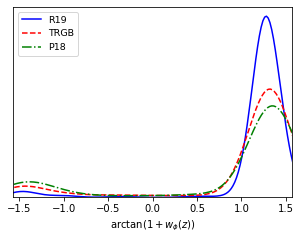

In [10]:
fig, ax = plt.subplots(figsize = (5, 3.5))

cl_list = ['b', 'r', 'g']
ls_list = ['-', '--', '-.']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    atw_samps = V_phip2_w_de_quint[H0_prior]['atw_samps'][-1]
    
    sb.kdeplot(atw_samps[1], color = cl_list[i],
               linestyle = ls_list[i], ax = ax,
               label = H0_prior)
    
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ax.set_xlabel('arctan($1 + w_\phi(z)$)')
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_yticks([])
ax.set_ylabel('')

plt.show()

Plot below shows the mean $\pm$ $1\sigma$ and the median surrounded by 68.2 \% of the probability mass for the extreme $z = 2$ distributions.

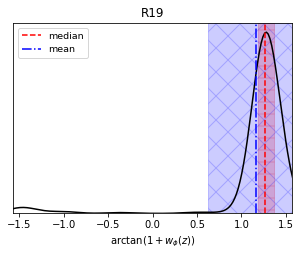

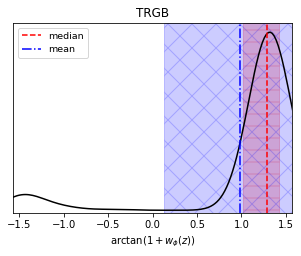

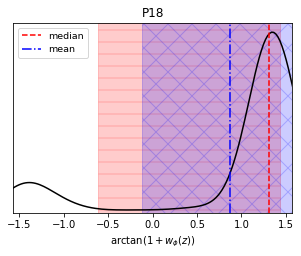

In [11]:
for H0_prior in H0_priors:
    
    atw_samps = V_phip2_w_de_quint[H0_prior]['atw_samps'][-1]
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    
    z_i = np.round(atw_samps[0], 1)
    sb.kdeplot(atw_samps[1], color = 'k',
               linestyle = '-', ax = ax)
    
    ax.axvline(np.percentile(atw_samps[1], 50),
               color = 'r', linestyle = '--', label = 'median')
    ax.axvspan(np.percentile(atw_samps[1], 50 - 34.1),
               np.percentile(atw_samps[1], 50 + 34.1),
               color = 'r', alpha = 0.2, hatch = '-')
    
    plt.axvline(np.mean(atw_samps[1]),
                color = 'b', linestyle='-.', label = 'mean')
    plt.axvspan(np.mean(atw_samps[1]) - np.std(atw_samps[1]),
                np.mean(atw_samps[1]) + np.std(atw_samps[1]),
                color = 'b', alpha = 0.2, hatch = 'x')
    
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w_\phi(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')
        
    plt.show()

### 3. Designer Horndeski theory (arXiv:1904.06294)

In cubic Horndeski theory, assuming shift symmetry, the $k$-esssence and braiding potentials can be obtained via a designer-approach (HDES) by $a \ priori$ taking in a constraint $H = H(X)$ to close the system of field equations. In this case, the potentials are given by
\begin{equation}
K(X) = - 3H_0^2 \Omega_\Lambda + \frac{J_c \sqrt{2X} H(X)^2}{H_0^2 \Omega_{m0}} - \frac{J_c \sqrt{2X} \Omega_\Lambda}{\Omega_{m0}}
\end{equation}
and
\begin{equation}
G_X = - \frac{2 J_c H'(X)}{3H_0^2 \Omega_{m0}}
\end{equation}
where $J_c$ (in units of $H_0$) is an integration constant describing the shift current's deviation from the dynamical attractor $J = 0$ and $\Omega_{m0}$ and $\Omega_\Lambda$ are the energy fractions from nonrelativistic matter and vacuum energy. In the HDES model, the Hubble function and the scalar field are taken to be related as
\begin{equation}
X = \frac{c_0}{H(z)^n}
\end{equation}
where $c_0$ (in units of $H_0^{n + 2}$) and $n$ are positive constants. In this case, the dark energy equation of state is given by
\begin{equation}
w_\phi(z) = -1 + \dfrac{J_c \sqrt{2 X(z)} \left( H(z)^2 - H_0^2 \Omega_\Lambda \right)}{3 H_0^4 \Omega_{m0} \Omega_\Lambda} - \dfrac{ 2 J_c (1 + z) \sqrt{2 X(z)} H(z) H'(z)}{9 H_0^4 \Omega_{m0} \Omega_\Lambda} .
\end{equation}

We start by coding the above equations.

In [12]:
def X_hdes(Hz, H0, c0, n):
    '''returns the HDES kinetic density'''
    
    return (c0*(H0**(n + 2)))/(Hz**n)

def dHdX_hdes(Hz, H0, c0, n):
    '''returns dH/dX given by the a priori X(H)'''

    return -(Hz**(n + 1))/(n*(c0*(H0**(n + 2))))

def K_hdes(Hz, H0, om0, ol0, c0, n, Jc):
    '''returns the k-essence potential of HDES'''
    
    X = X_hdes(Hz, H0, c0, n)
    
    term_1 = -3*(H0**2)*ol0
    term_2 = (Jc*H0)*np.sqrt(2*X)*(Hz**2)/((H0**2)*om0)
    term_3 = -(Jc*H0)*np.sqrt(2*X)*ol0/om0
    
    return term_1 + term_2 + term_3

def GX_hdes(Hz, H0, om0, c0, n, Jc):
    '''returns the braiding potential of HDES'''

    dHdX = dHdX_hdes(Hz, H0, c0, n)
    
    return -2*(Jc*H0)*dHdX/(3*(H0**2)*om0)

def w_hdes(z, Hz, Hpz, H0, om0, ol0, c0, n, Jc):
    '''returns the dark energy equation of state of HDES'''
    
    X = X_hdes(Hz, H0, c0, n)
    
    t1 = (Jc*H0)*np.sqrt(2*X)*((Hz**2) - ol0*(H0**2))/(3*(H0**4)*om0*ol0)
    t2 = -2*(Jc*H0)*(1 + z)*np.sqrt(2*X)*Hz*Hpz/(9*(H0**4)*om0*ol0)
    
    return -1 + t1 + t2

To proceed, we setup again the full covariance matrix for the parameters $(H(z), H'(z), H_0, \Omega_{m0}, \Omega_\Lambda)$. We then draw samples from a multivariate Gaussian with this full covariance matrix and obtain the mean and standard deviation of the resulting distribution. We setup this MC master function below.

In [13]:
def get_X_dHdX_K_GX_w_de_hdes(H0_prior, om0, sigom0,
                              ol0, sigol0, c0, n, Jc,
                              n_s = 1000):
    '''
    returns the mean and std of X(z), H'(X(z))
    K(X), G'(X), and w_DE(z) for HDES
    
    input:
    H0_prior = ('R16', 'TRGB', 'P18')
    om0 = prior matter energy fraction
    sigom0 = uncertainty in om0
    ol0 = vacuum energy fraction
    sigol0 = uncertainty in ol0
    (c0, n, Jc) = HDES parameters
    n_s = sampling size, default: n_s = 1000
    '''

    z = sbc_rec[H0_prior]['z']
    Hz = sbc_rec[H0_prior]['Hz']
    sigHz = sbc_rec[H0_prior]['sigHz']
    Hpz = sbc_rec[H0_prior]['Hpz']
    sigHpz = sbc_rec[H0_prior]['sigHpz']
    cov_Hz_Hpz = sbc_rec[H0_prior]['cov_Hz_Hpz']

    H0 = Hz[0]
    sigH0 = sigHz[0]

    # prepare mean and cov of full parameters
    ave_params = [np.array([Hz[i], Hpz[i], H0, om0, ol0])
                  for i in np.arange(0, len(Hz))]
    cov_params = [block_diag(C, sigH0**2,
                             sigom0**2, sigol0**2)
                  for C in cov_Hz_Hpz]

    X = np.zeros((len(z), 2))
    dHdX = np.zeros((len(z), 2))
    K = np.zeros((len(z), 2))
    GX = np.zeros((len(z), 2))
    w_de = np.zeros((len(z), 2))
    atw_de = np.zeros((len(z), 7))
    
    atw_de_z_samps = []
    i_samps = [int(len(z)*x) for x in np.linspace(0, 1, 5)]
    if len(z) in i_samps:
        len_z_index = i_samps.index(len(z))
        i_samps[len_z_index] = len(z) - 1

    for i in np.arange(0, len(z)):

        X_samples = np.zeros(n_s)
        dHdX_samples = np.zeros(n_s)
        K_samples = np.zeros(n_s)
        GX_samples = np.zeros(n_s)
        w_de_samples = np.zeros(n_s)
        atw_de_samples = np.zeros(n_s)

        for j in np.arange(0, n_s): # jth random draw

            Hz_j, Hpz_j, H0_j, om0_j, ol0_j = N(ave_params[i],
                                                cov_params[i])

            X_j = X_hdes(Hz_j, H0_j, c0, n)
            dHdX_j = dHdX_hdes(Hz_j, H0_j, c0, n)
            K_j = K_hdes(Hz_j, H0_j, om0_j, ol0_j, c0, n, Jc)
            GX_j = GX_hdes(Hz_j, H0_j, om0_j, c0, n, Jc)
            w_de_j = w_hdes(z[i], Hz_j, Hpz_j, H0_j,
                            om0_j, ol0_j, c0, n, Jc)

            X_samples[j] = X_j
            dHdX_samples[j] = dHdX_j
            K_samples[j] = K_j
            GX_samples[j] = GX_j
            w_de_samples[j] = w_de_j
            atw_de_samples[j] = np.arctan(1 + w_de_j)

        X[i][0] = np.mean(X_samples)
        X[i][1] = np.std(X_samples)

        dHdX[i][0] = np.mean(dHdX_samples)
        dHdX[i][1] = np.std(dHdX_samples)
        
        K[i][0] = np.mean(K_samples)
        K[i][1] = np.std(K_samples)
        
        GX[i][0] = np.mean(GX_samples)
        GX[i][1] = np.std(GX_samples)

        w_de[i][0] = np.mean(w_de_samples)
        w_de[i][1] = np.std(w_de_samples)
        
        atw_de[i][0] = np.mean(atw_de_samples)
        atw_de[i][1] = np.std(atw_de_samples)
        atw_de[i][2] = st.skew(atw_de_samples)
        atw_de[i][3] = st.kurtosis(atw_de_samples,
                                   fisher = True)
        atw_de[i][4] = np.percentile(atw_de_samples, 50) # median
        atw_de[i][5] = np.percentile(atw_de_samples,
                                     50 - 34.1) # 68.2% prob. mass
        atw_de[i][6] = np.percentile(atw_de_samples,
                                     50 + 34.1)
        
        if i in i_samps:
            
            atw_de_z_samps.append([z[i], atw_de_samples])
        
    return z, X, dHdX, K, GX, w_de, atw_de, atw_de_z_samps

We implement the sampling provided the GP reconstructions for each of the $H_0$ prior.

In [14]:
X_dHdX_K_GX_w_de_hdes = {}
n_s = 1000 # sampling size at each redshift  

# hdes parameters
c0 = 1
n = 1
Jc = 1

for H0_prior in H0_priors:
    
    z, X, dHdX, K, GX, w_de, atw_de, atw_samps = \
        get_X_dHdX_K_GX_w_de_hdes(H0_prior, om0_P18, sigom0_P18,
                                  ol0_P18, sigol0_P18,
                                  c0, n, Jc, n_s = n_s)
    
    X_dHdX_K_GX_w_de_dict = {}
    X_dHdX_K_GX_w_de_dict['z'] = z
    X_dHdX_K_GX_w_de_dict['X'] = X
    X_dHdX_K_GX_w_de_dict['dHdX'] = dHdX
    X_dHdX_K_GX_w_de_dict['K'] = K
    X_dHdX_K_GX_w_de_dict['GX'] = GX
    X_dHdX_K_GX_w_de_dict['w_de'] = w_de
    X_dHdX_K_GX_w_de_dict['atw_de'] = atw_de
    X_dHdX_K_GX_w_de_dict['atw_samps'] = atw_samps

    X_dHdX_K_GX_w_de_hdes[H0_prior] = X_dHdX_K_GX_w_de_dict

Here is a plot of the results for $X(z)$, $H'(X(z))$, $K(z)$, $G_X(z)$, and $w_{DE}(z)$ per $H_0$-prior.

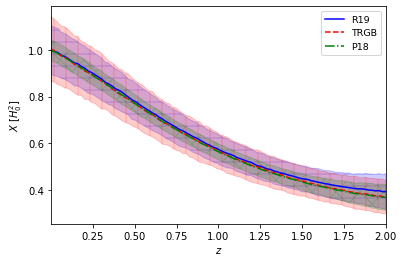

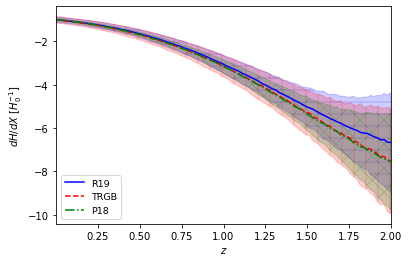

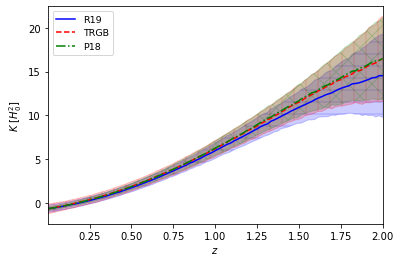

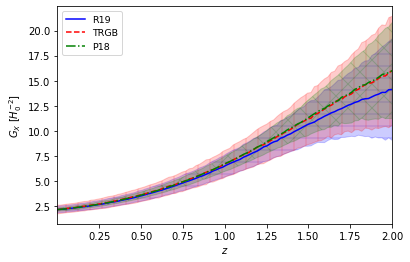

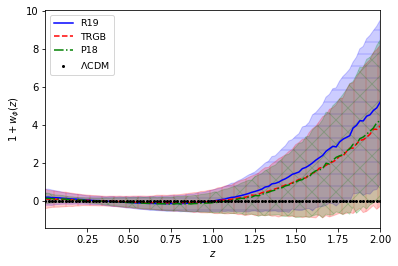

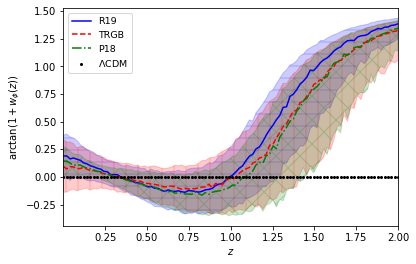

In [15]:
def plot_X_hdes(H0_prior, ls, fc, hatch):
    
    z = X_dHdX_K_GX_w_de_hdes[H0_prior]['z']
    X = X_dHdX_K_GX_w_de_hdes[H0_prior]['X']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(z, X[:, 0]/(H0**2), ls, label = H0_prior)
    plt.fill_between(z,
                     (X[:, 0] - 2*X[:, 1])/(H0**2),
                     (X[:, 0] + 2*X[:, 1])/(H0**2),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_dHdX_hdes(H0_prior, ls, fc, hatch):
    
    z = X_dHdX_K_GX_w_de_hdes[H0_prior]['z']
    dHdX = X_dHdX_K_GX_w_de_hdes[H0_prior]['dHdX']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(z, dHdX[:, 0]*H0, ls, label = H0_prior)
    plt.fill_between(z,
                     (dHdX[:, 0] - 2*dHdX[:, 1])*H0,
                     (dHdX[:, 0] + 2*dHdX[:, 1])*H0,
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_K_hdes(H0_prior, ls, fc, hatch):
    
    z = X_dHdX_K_GX_w_de_hdes[H0_prior]['z']
    K = X_dHdX_K_GX_w_de_hdes[H0_prior]['K']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(z, K[:, 0]/(H0**2), ls, label = H0_prior)
    plt.fill_between(z,
                     (K[:, 0] - 2*K[:, 1])/(H0**2),
                     (K[:, 0] + 2*K[:, 1])/(H0**2),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_GX_hdes(H0_prior, ls, fc, hatch):
    
    z = X_dHdX_K_GX_w_de_hdes[H0_prior]['z']
    GX = X_dHdX_K_GX_w_de_hdes[H0_prior]['GX']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(z, GX[:, 0]*(H0**2), ls, label = H0_prior)
    plt.fill_between(z,
                     (GX[:, 0] - 2*GX[:, 1])*(H0**2),
                     (GX[:, 0] + 2*GX[:, 1])*(H0**2),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_w_de_hdes(H0_prior, ls, fc, hatch):
    
    z = X_dHdX_K_GX_w_de_hdes[H0_prior]['z']
    w_de = X_dHdX_K_GX_w_de_hdes[H0_prior]['w_de']
    
    plt.plot(z, 1 + w_de[:, 0], ls, label = H0_prior)
    plt.fill_between(z,
                     1 + w_de[:, 0] - 2*w_de[:, 1],
                     1 + w_de[:, 0] + 2*w_de[:, 1],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_atw_de_hdes(H0_prior, ls, fc, hatch):
    
    z = X_dHdX_K_GX_w_de_hdes[H0_prior]['z']
    atw_de = X_dHdX_K_GX_w_de_hdes[H0_prior]['atw_de']
    
    plt.plot(z, atw_de[:, 4], ls, label = H0_prior)
    plt.fill_between(z, atw_de[:, 5], atw_de[:, 6],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
# designer X
fig = plt.figure()
plot_X_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_X_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_X_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$X$ [$H_0^2$]')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# designer dH/dX
fig = plt.figure()
plot_dHdX_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_dHdX_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_dHdX_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$dH/dX$ [$H_0^{-1}$]')
plt.legend(loc = 'lower left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# k-essence potential HDES
fig = plt.figure()
plot_K_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_K_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_K_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$K$ [$H_0^2$]')
plt.legend(loc='upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# braiding potential HDES
fig = plt.figure()
plot_GX_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_GX_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_GX_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$G_X$ [$H_0^{-2}$]')
plt.legend(loc='upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# dark energy equation of state
fig = plt.figure()
plot_w_de_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_w_de_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_w_de_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.plot(z_star, np.array([0]*len(z_star)),
         'k.', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel(r'$z$')
plt.ylabel(r'$1 + w_\phi(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# arctaned dark energy equation of state
fig = plt.figure()
plot_atw_de_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_atw_de_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_atw_de_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.plot(z_star, np.array([0]*len(z_star)),
         'k.', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel(r'$z$')
plt.ylabel(r'arctan($1 + w_\phi(z)$)')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

The potentials $K(X)$ and $G_X(X)$ can of course also be obtained.

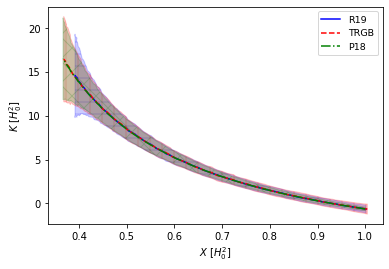

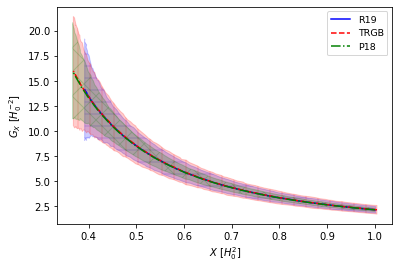

In [16]:
def plot_K_of_X_hdes(H0_prior, ls, fc, hatch):
    
    X = X_dHdX_K_GX_w_de_hdes[H0_prior]['X']
    K = X_dHdX_K_GX_w_de_hdes[H0_prior]['K']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(X[:, 0]/(H0**2), K[:, 0]/(H0**2),
             ls, label = H0_prior)
    plt.fill_between(X[:, 0]/(H0**2),
                     (K[:, 0] - 2*K[:, 1])/(H0**2),
                     (K[:, 0] + 2*K[:, 1])/(H0**2),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_GX_of_X_hdes(H0_prior, ls, fc, hatch):
    
    X = X_dHdX_K_GX_w_de_hdes[H0_prior]['X']
    GX = X_dHdX_K_GX_w_de_hdes[H0_prior]['GX']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(X[:, 0]/(H0**2), GX[:, 0]*(H0**2),
             ls, label = H0_prior)
    plt.fill_between(X[:, 0]/(H0**2),
                     (GX[:, 0] - 2*GX[:, 1])*(H0**2),
                     (GX[:, 0] + 2*GX[:, 1])*(H0**2),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)

# designer K(X)
fig = plt.figure()
plot_K_of_X_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_K_of_X_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_K_of_X_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$X$ [$H_0^2$]')
plt.ylabel('$K$ [$H_0^2$]')
plt.legend(loc='upper right', prop = {'size': 9.5})
plt.show()

# designer G'(X)
fig = plt.figure()
plot_GX_of_X_hdes('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_GX_of_X_hdes('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_GX_of_X_hdes('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$X$ [$H_0^2$]')
plt.ylabel('$G_X$ [$H_0^{-2}$]')
plt.legend(loc='upper right', prop = {'size': 9.5})
plt.show()

We also show the corresponding density plots for the compactified dark energy equation of state at sample redshifts throughout the evolution.

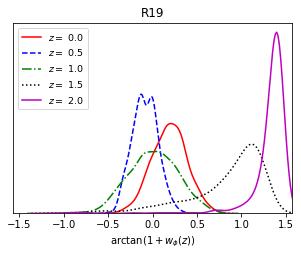

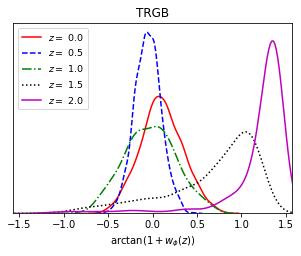

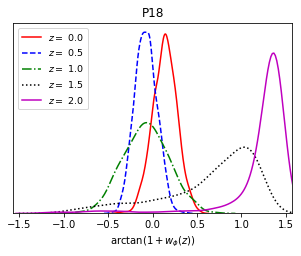

In [17]:
for H0_prior in H0_priors:
    
    atw_samps = X_dHdX_K_GX_w_de_hdes[H0_prior]['atw_samps']
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    cl_list = ['r', 'b', 'g', 'k', 'm']
    ls_list = ['-', '--', '-.', ':', '-']
    for i in np.arange(0, len(atw_samps)):
        z_i = np.round(atw_samps[i][0], 1)
        sb.kdeplot(atw_samps[i][1], color = cl_list[i],
                   linestyle = ls_list[i],
                   ax = ax, common_norm = True,
                   label = '$z =$ ' + str(z_i))
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w_\phi(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')    
        
    plt.show()

Here is the superposed plots of the posteriors at $z = 2$ per $H_0$ prior.

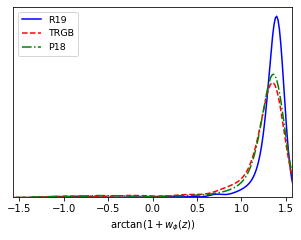

In [18]:
fig, ax = plt.subplots(figsize = (5, 3.5))

cl_list = ['b', 'r', 'g']
ls_list = ['-', '--', '-.']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    atw_samps = X_dHdX_K_GX_w_de_hdes[H0_prior]['atw_samps'][-1]
    
    sb.kdeplot(atw_samps[1], color = cl_list[i],
               linestyle = ls_list[i], ax = ax,
               label = H0_prior)
    
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ax.set_xlabel('arctan($1 + w_\phi(z)$)')
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_yticks([])
ax.set_ylabel('')

plt.show()

At $z = 2$, the probability plots and confidence intervals with respect to the mean and the median are shown below.

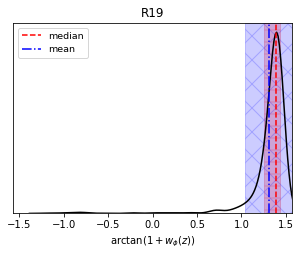

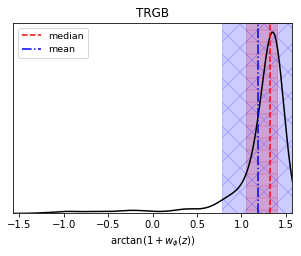

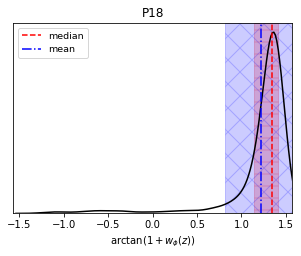

In [19]:
for H0_prior in H0_priors:
    
    atw_samps = X_dHdX_K_GX_w_de_hdes[H0_prior]['atw_samps'][-1]
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    
    z_i = np.round(atw_samps[0], 1)
    sb.kdeplot(atw_samps[1], color = 'k',
               linestyle = '-', ax = ax)
    
    ax.axvline(np.percentile(atw_samps[1], 50),
               color = 'r', linestyle = '--', label = 'median')
    ax.axvspan(np.percentile(atw_samps[1], 50 - 34.1),
               np.percentile(atw_samps[1], 50 + 34.1),
               color = 'r', alpha = 0.2, hatch = '-')
    
    plt.axvline(np.mean(atw_samps[1]),
                color = 'b', linestyle='-.', label = 'mean')
    plt.axvspan(np.mean(atw_samps[1]) - np.std(atw_samps[1]),
                np.mean(atw_samps[1]) + np.std(atw_samps[1]),
                color = 'b', alpha = 0.2, hatch = 'x')
    
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w_\phi(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')
        
    plt.show()

### 4. Tailoring cubic Horndeski theory (arXiv:1903.12578)

In cubic Horndeski theory, assuming shift symmetry, the braiding function can also be obtained via a tailoring-approach. This can be considered the $J(t) = 0$ limit of the designer approach. In this case, the scalar field's kinetic density $X$ is determined by
\begin{equation}
X[H] = 3 \left( H_0^2 \Omega_{m0} (1 + z)^3 + H_0^2 \Omega_\Lambda - H^2 \right)
\end{equation}
and
\begin{equation}
G_X[H] = -\frac{1}{3 H \sqrt{2 X[H]}} .
\end{equation}
The dark energy equation of state for tailoring Horndeski is given by
\begin{equation}
w_\phi(z) = \dfrac{ H(z) \left( 3H(z) - 2 ( 1 + z ) H'(z) \right) }{ 3 \left( -H(z)^2 + H_0^2 (1 + z)^3 \Omega_{m0} \right)  } .
\end{equation}
Notably, this is the same expression that can be obtained by just assuming that dark energy is a perfect fluid of equation of state $w(z) = P(z)/\rho(z)$.

We start by coding the above functions.

In [20]:
def X_tail(z, Hz, H0, om0, ol0):
    '''returns the kinetic density in tailoring Horndeski'''
    
    return 3*((H0**2)*om0*((1 + z)**3) + (H0**2)*ol0 - (Hz**2))

def GX2_tail(z, Hz, H0, om0, ol0):
    '''returns the square of the braiding potential,
    G'(X)^2, of tailoring Horndeski'''
    
    return 1/(18*(Hz**2)*X_tail(z, Hz, H0, om0, ol0))

def w_tail(z, Hz, Hpz, H0, om0):
    '''returns the dark energy equation of state of tailoring Horndeski'''
    
    return Hz*(3*Hz - 2*Hpz*(1 + z))/ \
           (3*(-(Hz**2) + (H0**2)*om0*((1 + z)**3)))

The MC master function for sampling $X$, $G'(X)$, and $w_{DE}(z)$ is setup in the following line.

In [21]:
def get_X_GX2_w_de_tail(H0_prior, om0, sigom0,
                        ol0, sigol0, n_s = 1000):
    '''
    returns the mean and std of X(z), G'(X)^2,
    and w_DE(z) for tailoring Horndeski
    
    input:
    H0_prior = ('R16', 'TRGB', 'P18')
    om0 = prior matter energy fraction
    sigom0 = uncertainty in om0
    ol0 = vacuum energy fraction
    sigol0 = uncertainty in ol0
    n_s = sampling size, default: n_s = 1000
    '''

    z = sbc_rec[H0_prior]['z']
    Hz = sbc_rec[H0_prior]['Hz']
    sigHz = sbc_rec[H0_prior]['sigHz']
    Hpz = sbc_rec[H0_prior]['Hpz']
    sigHpz = sbc_rec[H0_prior]['sigHpz']
    cov_Hz_Hpz = sbc_rec[H0_prior]['cov_Hz_Hpz']

    H0 = Hz[0]
    sigH0 = sigHz[0]

    # prepare mean and cov of full parameters
    ave_params = [np.array([Hz[i], Hpz[i], H0, om0, ol0])
                  for i in np.arange(0, len(Hz))]
    cov_params = [block_diag(C, sigH0**2,
                             sigom0**2, sigol0**2)
                  for C in cov_Hz_Hpz]

    X = np.zeros((len(z), 2))
    GX2 = np.zeros((len(z), 2))
    w_de = np.zeros((len(z), 2))
    atGX2 = np.zeros((len(z), 7))
    atw_de = np.zeros((len(z), 7))
    
    atGX2_z_samps = []
    atw_de_z_samps = []
    i_samps = [int(len(z)*x) for x in np.linspace(0, 1, 5)]
    if len(z) in i_samps:
        len_z_index = i_samps.index(len(z))
        i_samps[len_z_index] = len(z) - 1

    for i in np.arange(0, len(z)):

        X_samples = np.zeros(n_s)
        GX2_samples = np.zeros(n_s)
        w_de_samples = np.zeros(n_s)
        atGX2_samples = np.zeros(n_s)
        atw_de_samples = np.zeros(n_s)

        for j in np.arange(0, n_s):

            Hz_j, Hpz_j, H0_j, om0_j, ol0_j = N(ave_params[i],
                                                cov_params[i])

            X_j = X_tail(z[i], Hz_j, H0_j, om0_j, ol0_j)
            GX2_j = GX2_tail(z[i], Hz_j, H0_j, om0_j, ol0_j)
            w_de_j = w_tail(z[i], Hz_j, Hpz_j, H0_j, om0_j)

            X_samples[j] = X_j
            GX2_samples[j] = GX2_j
            w_de_samples[j] = w_de_j
            atGX2_samples[j] = np.arctan((H0_j**4)*GX2_j)
            atw_de_samples[j] = np.arctan(1 + w_de_j)

        X[i][0] = np.mean(X_samples)
        X[i][1] = np.std(X_samples)
        
        GX2[i][0] = np.mean(GX2_samples)
        GX2[i][1] = np.std(GX2_samples)

        w_de[i][0] = np.mean(w_de_samples)
        w_de[i][1] = np.std(w_de_samples)
        
        atGX2[i][0] = np.mean(atGX2_samples)
        atGX2[i][1] = np.std(atGX2_samples)
        atGX2[i][2] = st.skew(atGX2_samples)
        atGX2[i][3] = st.kurtosis(atGX2_samples,
                                  fisher = True)
        atGX2[i][4] = np.percentile(atGX2_samples, 50)
        atGX2[i][5] = np.percentile(atGX2_samples,
                                    50 - 34.1)
        atGX2[i][6] = np.percentile(atGX2_samples,
                                    50 + 34.1)
        
        atw_de[i][0] = np.mean(atw_de_samples)
        atw_de[i][1] = np.std(atw_de_samples)
        atw_de[i][2] = st.skew(atw_de_samples) 
        atw_de[i][3] = st.kurtosis(atw_de_samples,
                                   fisher = True)
        atw_de[i][4] = np.percentile(atw_de_samples, 50)
        atw_de[i][5] = np.percentile(atw_de_samples,
                                     50 - 34.1)
        atw_de[i][6] = np.percentile(atw_de_samples,
                                     50 + 34.1)
        
        if i in i_samps:
            
            atGX2_z_samps.append([z[i], atGX2_samples])
            atw_de_z_samps.append([z[i], atw_de_samples])
        
    return z, X, GX2, w_de, atGX2, atw_de, \
           atGX2_z_samps, atw_de_z_samps

The sampling for each $H_0$ prior is performed below.

In [22]:
X_GX2_w_de_tail = {}
n_s = 1000 # sampling size at each redshift  

for H0_prior in H0_priors:
    
    z, X, GX2, w_de, atGX2, atw_de, atGX2_samps, atw_samps= \
        get_X_GX2_w_de_tail(H0_prior, om0_P18, sigom0_P18,
                            ol0_P18, sigol0_P18, n_s = n_s)
    
    X_GX2_w_de_dict = {}
    X_GX2_w_de_dict['z'] = z
    X_GX2_w_de_dict['X'] = X
    X_GX2_w_de_dict['GX2'] = GX2
    X_GX2_w_de_dict['w_de'] = w_de
    X_GX2_w_de_dict['atGX2'] = atGX2
    X_GX2_w_de_dict['atw_de'] = atw_de
    X_GX2_w_de_dict['atGX2_samps'] = atGX2_samps
    X_GX2_w_de_dict['atw_samps'] = atw_samps

    X_GX2_w_de_tail[H0_prior] = X_GX2_w_de_dict

Finally, it's time to show some plots. We prepare this with the plotting functions below.

In [23]:
def plot_X_tail(H0_prior, ls, fc, hatch):
    
    z = X_GX2_w_de_tail[H0_prior]['z']
    X = X_GX2_w_de_tail[H0_prior]['X']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(z, X[:, 0]/(H0**2), ls, label = H0_prior)
    plt.fill_between(z,
                     (X[:, 0] - 2*X[:, 1])/(H0**2),
                     (X[:, 0] + 2*X[:, 1])/(H0**2),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_GX2_tail(H0_prior, ls, fc, hatch):
    
    z = X_GX2_w_de_tail[H0_prior]['z']
    GX2 = X_GX2_w_de_tail[H0_prior]['GX2']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(z, GX2[:, 0]*(H0**4), ls, label = H0_prior)
    plt.fill_between(z,
                     (GX2[:, 0] - 2*GX2[:, 1])*(H0**4),
                     (GX2[:, 0] + 2*GX2[:, 1])*(H0**4),
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)

def plot_atGX2_tail(H0_prior, ls, fc, hatch):
    
    z = X_GX2_w_de_tail[H0_prior]['z']
    atGX2 = X_GX2_w_de_tail[H0_prior]['atGX2']

    ax.plot(z, atGX2[:, 4], ls, label = H0_prior)
    ax.fill_between(z, atGX2[:, 5], atGX2[:, 6],
                    alpha = .2, facecolor = fc,
                    edgecolor = fc, hatch = hatch)
    
    axin.plot(z, atGX2[:, 4], ls, label = H0_prior)
    axin.fill_between(z, atGX2[:, 5], atGX2[:, 6],
                      alpha = .2, facecolor = fc,
                      edgecolor = fc, hatch = hatch)
    
def plot_atGX2_of_X_tail(H0_prior, ls, fc, hatch):
    
    X = X_GX2_w_de_tail[H0_prior]['X']
    atGX2 = X_GX2_w_de_tail[H0_prior]['atGX2']
    
    H0 = sbc_rec[H0_prior]['Hz'][0]
    
    plt.plot(X[:, 0]/(H0**2), atGX2[:, 4], ls, label = H0_prior)
    plt.fill_between(X[:, 0]/(H0**2),
                     atGX2[:, 5], atGX2[:, 6],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_w_de_tail(H0_prior, ls, fc, hatch):
    
    z = X_GX2_w_de_tail[H0_prior]['z']
    w_de = X_GX2_w_de_tail[H0_prior]['w_de']
    
    plt.plot(z, 1 + w_de[:, 0], ls, label = H0_prior)
    plt.fill_between(z,
                     1 + w_de[:, 0] - 2*w_de[:, 1],
                     1 + w_de[:, 0] + 2*w_de[:, 1],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_atw_de_tail(H0_prior, ls, fc, hatch):
    
    z = X_GX2_w_de_tail[H0_prior]['z']
    atw_de = X_GX2_w_de_tail[H0_prior]['atw_de']
    
    plt.plot(z, atw_de[:, 4], ls, label = H0_prior)
    plt.fill_between(z, atw_de[:, 5], atw_de[:, 6],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)

Here is a plot of $X$ and $G_X^2$ as a function of the redshift.

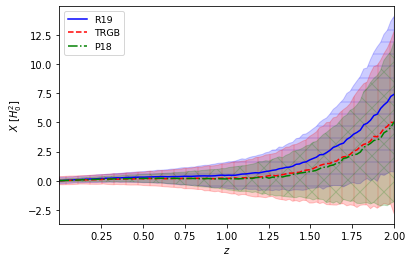

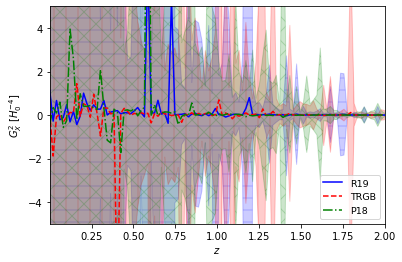

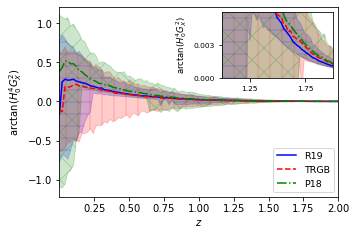

In [24]:
# tailored kinetic density X
fig = plt.figure()
plot_X_tail('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_X_tail('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_X_tail('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$X$ [$H_0^2$]')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# tailored braiding potential dG/dX
fig = plt.figure()
plot_GX2_tail('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_GX2_tail('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_GX2_tail('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$z$')
plt.ylabel('$G_X^2$ [$H_0^{-4}$]')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.ylim(-5, 5)
plt.show()

# arctaned-tailored braiding potential dG/dX
fig, ax = plt.subplots(figsize = (5, 3.5))
axin = inset_axes(ax, width = '40%', height = '35%',
                  loc = 'upper right')
plot_atGX2_tail('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_atGX2_tail('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_atGX2_tail('P18', ls = 'g-.', fc = 'g', hatch = 'x')
ax.set_xlabel('$z$')
ax.set_ylabel('arctan($H_0^4 G_X^2$)')
ax.legend(loc = 'lower right', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
axin.xaxis.set_tick_params(labelsize = 7.5)
axin.yaxis.set_tick_params(labelsize = 7.5)
axin.set_xlim(z_max/2, z_max)
axin.set_ylim(0, 6e-3)
axin.set_xticks([1.25, 1.75])
axin.set_yticks([0, 0.003])
axin.set_ylabel('arctan($H_0^4 G_X^2$)', fontsize = 8.5)
plt.show()

Also, here is $G_X^2(X)$, revealing the explicit dependence of the braiding potential on the kinetic density.

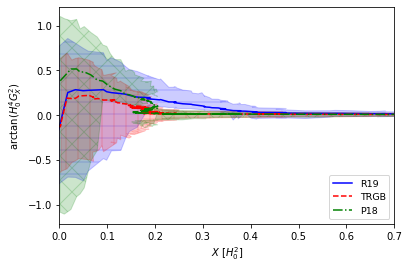

In [25]:
fig = plt.figure()
plot_atGX2_of_X_tail('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_atGX2_of_X_tail('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_atGX2_of_X_tail('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.xlabel('$X$ [$H_0^2$]')
plt.ylabel('arctan($H_0^4 G_X^2$)')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(0, 0.7)
plt.show()

And, of course, here is the dark energy equation of state as a function of the redshift.

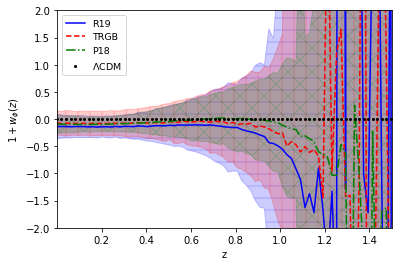

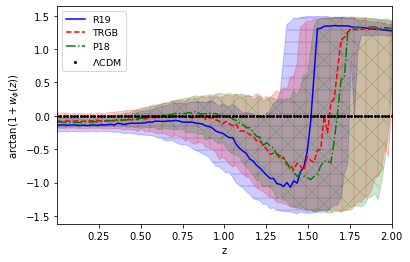

In [26]:
# dark energy equation of state
fig = plt.figure()
plot_w_de_tail('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_w_de_tail('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_w_de_tail('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.plot(z_star, np.array([0]*len(z_star)),
         'k.', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('$1 + w_\phi(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max*0.75)
plt.ylim(-2, 2)
plt.show()

# arctaned dark energy equation of state
fig = plt.figure()
plot_atw_de_tail('R19', ls = 'b-', fc = 'b', hatch = '-')
plot_atw_de_tail('TRGB', ls = 'r--', fc = 'r', hatch = '|')
plot_atw_de_tail('P18', ls = 'g-.', fc = 'g', hatch = 'x')
plt.plot(z_star, np.array([0]*len(z_star)),
         'k.', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('arctan($1 + w_\phi(z)$)')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

We present below the distributions of the compactified braiding potential for different redshifts.

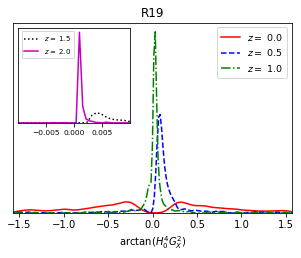

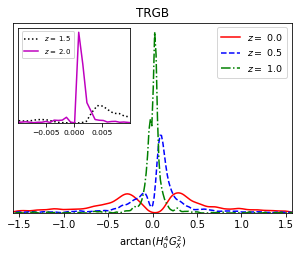

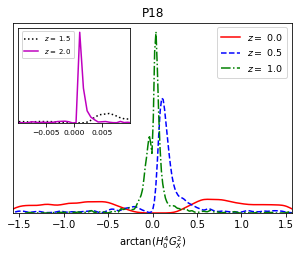

In [27]:
def trim_arr(arr, x_min, x_max):
    '''trims an array at bounds x_min and x_max'''
    
    arr_trim = []
    for each in arr:
        if (each > x_min) and (each < x_max):
            arr_trim.append(each)
            
    return np.array(arr_trim)

for H0_prior in H0_priors:
    
    atGX2_samps = X_GX2_w_de_tail[H0_prior]['atGX2_samps']
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    axin = inset_axes(ax, width = '40%', height = '50%',
                      loc = 'upper left')
    cl_list = ['r', 'b', 'g', 'k', 'm']
    ls_list = ['-', '--', '-.', ':', '-']
    for i in np.arange(0, len(atGX2_samps)):
        
        z_i = np.round(atGX2_samps[i][0], 1)
        
        if z_i <= 1:
            sb.kdeplot(atGX2_samps[i][1], bw_adjust = 0.3,
                       color = cl_list[i], linestyle = ls_list[i], 
                       ax = ax, common_norm = True, 
                       label = '$z =$ ' + str(z_i))
        else:
            atGX2_trimmed = trim_arr(atGX2_samps[i][1],
                                     -0.1, 0.1)
            sb.kdeplot(atGX2_trimmed, color = cl_list[i],
                       linestyle = ls_list[i],
                       common_norm = True,
                       bw_adjust = 0.1, ax = axin,
                       label = '$z =$ ' + str(z_i))
            
    ax.set_title(H0_prior)
    ax.legend(loc = 'upper right', prop = {'size': 9.5})
    ax.set_xlabel('arctan($H_0^4 G_X^2$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')
    
    axin.legend(loc = 'upper left', prop = {'size': 7})
    axin.xaxis.set_tick_params(labelsize = 7.5)
    axin.set_xlim(-0.01, 0.01)
    axin.set_xticks([-0.005, 0, 0.005])
    axin.set_yticks([])
    axin.set_ylabel('')
        
    plt.show()

Below, the distributions of $\arctan\left(H_0^4G_X^2\right)$ at $z = 2$ are plotted for the different $H_0$ priors.

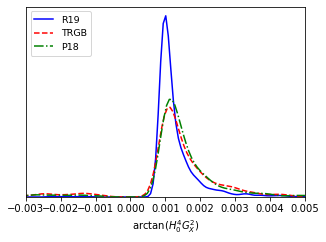

In [28]:
fig, ax = plt.subplots(figsize = (5, 3.5))
cl_list = ['b', 'r', 'g']
ls_list = ['-', '--', '-.']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    atGX2_samps = X_GX2_w_de_tail[H0_prior] \
                  ['atGX2_samps'][-1][1]
    atGX2_trimmed = trim_arr(atGX2_samps, -0.005, 0.01)
    sb.kdeplot(atGX2_trimmed, color = cl_list[i],
               linestyle = ls_list[i], bw_adjust = 0.5,
               common_norm = True, ax = ax, label = H0_prior)
    
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ax.set_xlabel('arctan($H_0^4 G_X^2$)')
ax.set_xlim(-0.003, 0.005)
ax.set_yticks([])
ax.set_ylabel('')
plt.show()

Also, here are the correponding compactified dark energy equation of state for sample redshifts.

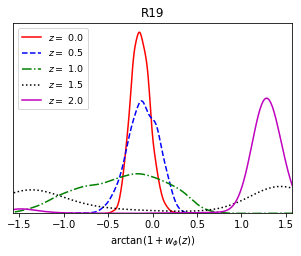

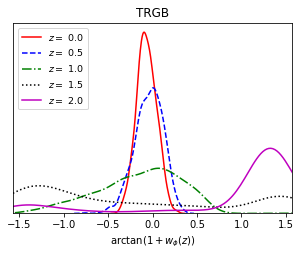

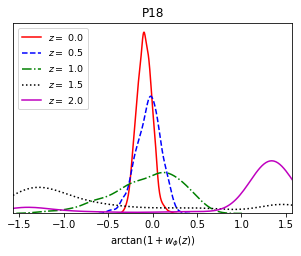

In [29]:
for H0_prior in H0_priors:
    
    atw_samps = X_GX2_w_de_tail[H0_prior]['atw_samps']
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    cl_list = ['r', 'b', 'g', 'k', 'm']
    ls_list = ['-', '--', '-.', ':', '-']
    for i in np.arange(0, len(atw_samps)):
        z_i = np.round(atw_samps[i][0], 1)
        sb.kdeplot(atw_samps[i][1], color = cl_list[i],
                   linestyle = ls_list[i],
                   ax = ax, common_norm = True,
                   label = '$z =$ ' + str(z_i))
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w_\phi(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')    
        
    plt.show()

The superposed $z = 2$ posteriors of $\arctan(1 + w_\phi(z))$ are shown below.

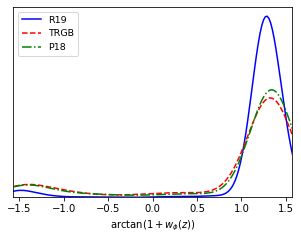

In [30]:
fig, ax = plt.subplots(figsize = (5, 3.5))

cl_list = ['b', 'r', 'g']
ls_list = ['-', '--', '-.']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    atw_samps = X_GX2_w_de_tail[H0_prior]['atw_samps'][-1]
    
    sb.kdeplot(atw_samps[1], color = cl_list[i],
               linestyle = ls_list[i], ax = ax,
               label = H0_prior, common_norm = True)
    
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ax.set_xlabel('arctan($1 + w_\phi(z)$)')
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_yticks([])
ax.set_ylabel('')

plt.show()

At $z = 2$, here are the distributions of $\arctan(1 + w_\phi(z))$ for the different priors.

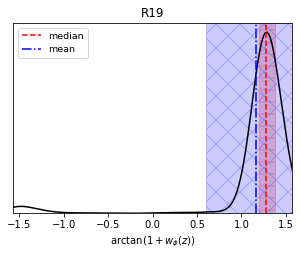

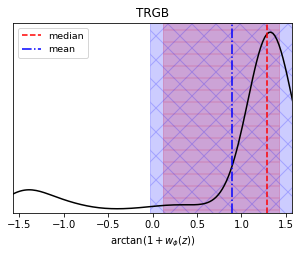

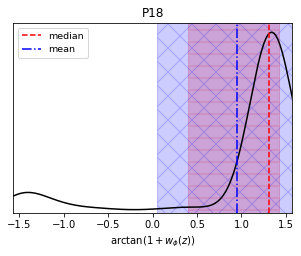

In [31]:
for H0_prior in H0_priors:
    
    atw_samps = X_GX2_w_de_tail[H0_prior]['atw_samps'][-1]
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    
    z_i = np.round(atw_samps[0], 1)
    sb.kdeplot(atw_samps[1], color = 'k',
               linestyle = '-', ax = ax)
    
    ax.axvline(np.percentile(atw_samps[1], 50),
               color = 'r', linestyle = '--', label = 'median')
    ax.axvspan(np.percentile(atw_samps[1], 50 - 34.1),
               np.percentile(atw_samps[1], 50 + 34.1),
               color = 'r', alpha = 0.2, hatch = '-')
    
    plt.axvline(np.mean(atw_samps[1]),
                color = 'b', linestyle='-.', label = 'mean')
    plt.axvspan(np.mean(atw_samps[1]) - np.std(atw_samps[1]),
                np.mean(atw_samps[1]) + np.std(atw_samps[1]),
                color = 'b', alpha = 0.2, hatch = 'x')
    
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w_\phi(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')
        
    plt.show()

### *Constraints on the dark energy equation of state

In this last special section, we summarize the constraints on the dark energy equation of state obtained via the different Horndeski construction methods above and different $H_0$ priors.

In [32]:
# quintessence
print('Quintessence')
for H0_prior in H0_priors:
    w0 = V_phip2_w_de_quint[H0_prior]['w_de'][0]
    print(H0_prior, 'w_DE =' , w0[0], '+/-', w0[1])
    
# designer Horndeski (HDES)
print()
print('Designer Horndeski')
for H0_prior in H0_priors:
    w0 = X_dHdX_K_GX_w_de_hdes[H0_prior]['w_de'][0]
    print(H0_prior, 'w_DE =' , w0[0], '+/-', w0[1])
    
# tailoring Horndeski
print()
print('Tailoring Horndeski')
for H0_prior in X_GX2_w_de_tail:
    w0 = X_GX2_w_de_tail[H0_prior]['w_de'][0]
    print(H0_prior, 'w_DE =' , w0[0], '+/-', w0[1])

Quintessence
R19 w_DE = -1.1319889855933907 +/- 0.10933230656834664
TRGB w_DE = -1.0741050092533628 +/- 0.11615207686252536
P18 w_DE = -1.0971162826710055 +/- 0.08520268887925907

Designer Horndeski
R19 w_DE = -0.8020654631923321 +/- 0.21266702852198163
TRGB w_DE = -0.8927646146563855 +/- 0.2553879158778994
P18 w_DE = -0.859626354270285 +/- 0.14098390848206002

Tailoring Horndeski
R19 w_DE = -1.13866016466656 +/- 0.11013061738144556
TRGB w_DE = -1.0682808116643698 +/- 0.11361711244721522
P18 w_DE = -1.0924573117894234 +/- 0.08521867256212347
